[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)
# Solubility calculation assignment, PharmSci 175/275

Solubility estimation/prediction is a huge problem in drug discovery. Here, we will attempt to build a simple empirical model for solubility prediction as in a recent literature challenge. We will take a set of ~100 solubility values, and develop a simple model which reproduces those values reasonably well, then test this model on a new set of compounds (a test set). To put it another way, we have a test set and a training set, and want to use the known solubilities from the training set to predict solubilities for the test set. 

This builds on the solubility challenge of [Llinàs et al.](https://dx.doi.org/10.1021/ci800058v) and the conclusions/subsequent work of [Hopfinger et al.](https://dx.doi.org/10.1021/ci800436c).


## Overview

Solubility calculation is an important problem for drug discovery, partly because it is so important that drugs be soluble. Solubility is an important factor in the design of orally bioavailable drugs, as we have discussed in class. However, no good physical models are available for work in this area yet, so most of the models for solubility estimation are empirical, based on measuring a set of simple molecular properties for molecules and combining these to estimate a solubility in some way, based on calibration to experimental data.

Recently, Llinàs et al., [(J. Chem. Inf. Model 48:1289 (2008))](https://dx.doi.org/10.1021/ci800058v) posed a challenge: Can you predict a set of 32 solubilities on a test set, using a database (training set) of 100 reliable solubility measurements? Follow up work [(Hopfinger et al., J. Chem. Inf. Model 49:1 (2009))](https://dx.doi.org/10.1021/ci800436c) provided the solubility measurements of the test set and assessed performance of a wide variety of solubility estimation techniques in this challenge.

Here, your job is to construct several simple linear models to predict solubilities using the training set of roughly 100 compounds, and then test their performance on the test set, comparing them with one another, with a null model, and with the performance of research groups which participated in the challenge. You should also implement and test a simple variant of the LINGO-based approach of Vidal et al. (J. Chem. Inf. Model 45(2):386-393 (2005)). 

A good deal of the technology you will need to use here is provided for you, including example models. Your job in this assignment is simply going to be to adjust the Python code I have provided to build several (five or more) new models for predicting solubilities, plus one based on the approach of Vidal, and compare their performance to select your favorite. 

## Some setup notes

In this directory, you should also find a module you can import which will help with some statistics -- `tools.py`. You will also find two directories containing structures of molecules in the different sets -- `llinas_predict`, containing molecules whose solubilities we want to predict, and `llinas_set`, containing molecules in the training set. Additionally, in the `scripts` directory there is `solubilities.pickle` which contains solubility data (not human readable).  

I also provide some fairly extensive example code below which you can use as the basis for your assignment. To briefly summmarize the provided code (you can see more detail by reading the comments and code below) it loads the structures of the molecules and their names, computes a reasonably extensive set of descriptros or properties of the different molecules and loads in the actual solubility data. It then proceeds to build two extremely simple models for predicting solubilities based on a simple linear combination/fit of physical properties. You will be able to use this part of the program as a template for building your own solubility models.

## For solubility prediction, we'll use a series of *descriptors*

Descriptors are properties of our molecule which might (or might not) be related to the solubility. For example, we might think that solubility will in general tend to go down as molecular weight goes up, and go up as polarity increases (or go down as polarity decreases) and so on. 

Here, let's take a sample molecule and calculate a series of descriptors which we might want to use in constructing a simple solubility model. 

## Installing Packages

***If you are running this on Google Colab, please add the installation blocks from the [getting started notebook](https://github.com/MobleyLab/drug-computing/blob/master/uci-pharmsci/Getting_Started.ipynb) or [condacolab](https://github.com/aakankschit/drug-computing/blob/master/uci-pharmsci/Getting_Started_condacolab.ipynb) here and then execute the code below***

In [ ]:
from openeye.oechem import *
from openeye.oemolprop import *
from openeye.oeiupac import *
from openeye.oezap import *
from openeye.oeomega import *
import numpy as np
import scipy.stats

#Initialize an OpenEye molecule
mol = OEMol()

#let's look at phenol
OEParseIUPACName( mol, 'naphthalene' )

#Generate conformation
omega = OEOmega()
omega(mol)

#Here one of the descriptors we'll use is the calculated solvation free energy, from OpenEye's ZAP electrostatics solver
#Get zap ready for electrostatics calculations
zap = OEZap()
zap.SetInnerDielectric( 1.0 )
zap.SetGridSpacing(0.5)
area = OEArea()

#Reduce verbosity
OEThrow.SetLevel(OEErrorLevel_Warning)


#Let's print a bunch of properties
#Molecular weight
print( "Molecular weight: %.2f" % OECalculateMolecularWeight(mol) )
#Number of atoms
print( "Number of atoms: %s" % mol.NumAtoms() ) 
#Number of heavy atoms
print( "Number of heavy atoms: %s" % OECount(mol, OEIsHeavy() ) )
#Number of ring atoms
print( "Number of ring atoms: %s" % OECount(mol, OEAtomIsInRing() ) )
#Number of halogens
print( "Number of halogens: %s" % OECount( mol, OEIsHalogen() ))
print ("Number of nitrogens: %s" % OECount( mol, OEIsNitrogen() ) )
print( "Number of oxygens: %s" % OECount( mol, OEIsOxygen() ) )
print( "Number of rotatable bonds: %s" % OECount( mol, OEIsRotor() ) )

#Calculated logP - water to octanol partitioning coefficient (which is often something which may correlate somewhat with solubility)
print( "Calculated logP: %.2f" %  OEGetXLogP( mol ) )

print( "Number of aromatic rings: %s" % OEGetAromaticRingCount( mol ) )

    
    
#Calculate lots of other properties using molprop toolkit as per example in OE MolProp manual
#Handle the setup of 'filter', which computes lots of properties with the goal of filtering compounds. Here we'll not do any filtering
#and will use it solely for property calculation
filt = OEFilter()
ostr = oeosstream()
pwnd = False
filt.SetTable( ostr, pwnd)
headers = ostr.str().decode().split('\t')
ostr.clear()
filt(mol)
fields = ostr.str().decode().split('\t')
tmpdct = dict( zip(headers, fields) ) #Format the data we need into a dictionary for easy extraction

print("Polar surface area: %s" % tmpdct[ '2d PSA' ] )
print("Number of hbond donors: %s" % int(tmpdct['hydrogen-bond donors']) )
print("Number of hbond acceptors: %s" % int(tmpdct['hydrogen-bond acceptors']) )
print ("Number of rings: %s" % int(tmpdct['number of ring systems']) )
#print(tmpdct.keys())

#Quickly estimate hydration free energy, or a value correlated with that -- from ZAP manual
#Do ZAP setup for molecule
OEAssignBondiVdWRadii(mol)
OEMMFFAtomTypes(mol)
OEMMFF94PartialCharges(mol)
zap.SetMolecule( mol )
solv = zap.CalcSolvationEnergy()
aval = area.GetArea( mol )
#Empirically estimate solvation free energy (hydration)
solvation = 0.59*solv + 0.01*aval #Convert electrostatic part to kcal/mol; use empirically determined kcal/sq angstrom value times surface area term
print ("Calculated solvation free energy: %.2f" % solvation)

Molecular weight: 128.17
Number of atoms: 18
Number of heavy atoms: 10
Number of ring atoms: 10
Number of halogens: 0
Number of nitrogens: 0
Number of oxygens: 0
Number of rotatable bonds: 0
Calculated logP: 3.57
Number of aromatic rings: 2
Polar surface area: 0.00
Number of hbond donors: 0
Number of hbond acceptors: 0
Number of rings: 1
Calculated solvation free energy: -4.13


## Linear models for solubility: Understanding your task

Here, your first job is to construct some linear models for solubility and attempt to use them to predict solubilities for a test set of molecules. 
Many different models for solubilities would be possible. Here, however, we focus on linear models -- that is, models having the form:
$y = mx + b$

where $y$ is the solubility, $m$ and $b$ are constants, and $x$ is some descriptor of the molecule. Or with two variables:
$y = mx + nz + b$

Here we've added a second descrptor, $z$, and another constant, $n$. Still more generally, we could write:

$y = b + \sum_i m_i x_i$

In this case, we now have a constant, $b$, and a set of other constants, $m_i$, and descriptors, $x_i$; the sum runs over all values of $i$.

What does this all mean? Basically, we are going to assume that we can predict solubilities out of some linear combination of descriptors or molecular properties. For example, (as a null model) I might assume that solubility can be predicted simply based on molecular weight -- perhaps heavier compounds will in general be less (or more) soluble. I might write:

$y = m\times MW + b$

This has the form $y=mx + b$ but I replaced $x$ with $MW$, the molecular weight. To fit this model, I would then need to find the coefficients $m$ and $b$ to give the best agreement with the actual solublity data.

Here, I would first develop parameters $m$ and $b$ to fit my training set -- that is, I would fit $m$ and $b$ on the training set data, the (roughly 100) compounds provided in the first paper. Then, I would apply the same $m$ and $b$ to the test set data to see how well I can predict the 32 "new" compounds. 

In this project, you will test the "null model" I just described (which turns out actually to be not too bad, here!), as well as another model I built, which has the form

$y = m\times MW +n\times F + b$
where I've added a new descriptor, F, which is the calculated hydration free energy of the compound (calculated with a PB model). So my model predicts that solubility is a constant plus some factor times molecular weight and another factor times the calculated hydration free energy.

Finding the parameters $m$, $n$, and $b$ is a very simple via a least-squares fit. This is done for you within Python. 
Here you will need to develop several of your own linear solubility prediction models (as discussed below) and test their performance.

## Lingo-based solubility models

In class, when we discussed the LINGO similarity approach, I mentioned in passing that this approach had been used to attempt to estimate solubilities based on functional group/LINGO fragment contributions. This was done in work by Vidal et al. (J. Chem. Inf. Model 45(2):386-393 (2005)).

While the approach of Vidal et al. is outside the scope of this assignment, you should quickly implement a related idea (optional for undergraduates). Particularly, you should test what happens if, for each compound in your test set you simply predict the value of the most similar (by LINGO) compound in the training set. This will allow you to quickly test how well you can predict solubilities based on pure molecular similarity to compounds in your training set. Obviously your training set is limited in size, but it’s still a worthwhile test.

## Your assignment: Build and test at least five new solubility models plus (for graduate students) the Lingo-based approach

This section deals with what you are trying to do. A separate section, below, deals with the “how to” aspect. Your goal in this project is to build and test five new solubility models plus the approach based on LINGO similarity. 

This section focuses primarily on building linear solubility models; I’ll assume the LINGO similarity idea is simple enough you can implement it yourself. (Though if you like,  for extra credit, you can combine it with a linear solubility model to see if it can do better than either approach alone.)

**Building solubility models**: Building a solubility model, here, amounts to selecting a set of descriptors (possible choices are listed below), getting their values, and then doing a least squares fit on the training set (the knowns) to find the parameters.

**Testing solubility models**: Testing a solubility model, here, means taking the parameters that were found for a specific solubility model and applying that model to the test set, predicting solubility values and seeing how well the predicted values compare to experiment. 

**Descriptors**: Here, a variety of molecular descriptors are precalculated for you. These are stored below within a dictionary, `compounds`, such that `compounds[molname][descriptorname]` gives you the value of the descriptor named `descriptorname` for compound name `molname`. For example, `compounds['naloxone']['mw']` gives the molecular weight of naloxone. Here are the descriptors available to you below, by their abbreviation (i.e. "mw" for molecular weight) with a small amount of information about each:
- `mw`: Molecular weight
- `numatoms`: Number of atoms including hydrogens
- `heavyatoms`: Number of heavy atoms
- `ringatoms`: Number of atoms in rings
- `halogens`: Number of halogens
- `nitrogens`: Number of nitrogens
- `oxygens`: Number of oxygens
- `rotatable`: Number of rotatable bonds
- `XlogP`: Calculated logP (water to octanol partitioning coefficient)
- `aromaticrings`: Number of aromatic rings
- `PSA`: Polar surface area of the compound
- `SA`: Surface area of the compound
- `hbond-donors`: Number of hydrogen bond donors
- `hbond-acceptors`: Number of hydrogen bond acceptors
- `rings`: Number of rings 
- `hydration`: Estimated hydration free energy (essentially a measure of the interactions with solvent)


As you might guess, some of these probably ought to have more to do with solubility than others. The number of atoms in rings is, perhaps, not that related to solubility, nor should the number of rings be that related to solubility. Perhaps there may generally be a trend that larger compounds are somewhat less soluble -- not for chemical reasons, but rather for reasons of pharmaceutical interest (many drugs tend to be somewhat large and somewhat less soluble), so some of the descriptors correlated with molecular weight (such as number of atoms, number of heavy atoms, etc.) may be better predictors of solubility than you might guess. On the other hand, hydration free energy is closely related to solubility (it’s the solution part of a solubility), and some of the other descriptors may be as well.

In any case, one of the goals here is to build a variety of different models to start seeing (a) how you typically can get better results in the training set as you keep adding more descriptors; (b) which descriptors tend to work better; and (c) how well your best model(s) can do on the test set. You may also gain some insight into (d), how to avoid overfitting. 

So, overall, you should select some specific descriptors you think are interesting, and build models involving those. Be sure to also test the approach based on LINGO similarity if you are a grad student (you will have to implement it based on the LINGO examples already seen earlier in the course).

### Solubility versus log S

Solubilities potentially cover a huge range. In fact, this dataset tends to have a relatively large number of compounds which are not very soluble, and a small number which are extremely soluble. What this means is that if we aren’t careful, the few extremely soluble compounds will end up playing a huge role in the development of our models. Thus, here, it actually makes more sense to work with the logarithm of the solubility, which we’ll call logS. So, in our project, our real goal is going to be to calculate the logS, not the solubility itself. My code has been written to work with logS, so henceforth when I talk about solubility I’m really going to be talking about logS.

### How to achieve your goal: Some specific hints

To get going on the problem, view the code below and find the section below dealing with building first and second simple models. Here, I provide two initial models noted above -- one based on molecular weight as a descriptor, and one based on molecular weight plus hydration free energy. For your starting point, read through the code for ["Build a first simple model"](#Build-a-first-simple-model) based on hydration free energy and molecular weight. You will basically need to copy this code and modify it to handle your descriptors.

Take a quick look for the code for ["Build a second simple model"](#Build-another-simple-model). There, the first step, before we can build a model, is to get values of our descriptors for the molecules of interest. We’ve already done that for the molecular weight in ["Build a first simple model"](#Build-a-first-simple-model) (refer there if you like), so this code begins by getting the hydration free energies for the knowns and the molecules we want to predict. The code is commented, but basically what you need to know is that if you want to switch to another metric, say, number of rings, you’d take the code like

```python
known_hydr = [ compounds[mol]['hydration'] for mol in knownnames ] 
known_hydr = np.array(known_hydr)
```
and switch it to
```python
known_rings = [ compounds[mol]['rings'] for mol in knownnames ] 
known_rings = np.array(known_rings)
```

This gets descriptor values for the number of rings for the knowns (training set molecules). You’d then need to do the same for changing `p_hydr` into `p_rings` (number of rings for the "prediction" or test set molecules).

Then, in the next section, there least squares fit is done to actually get the parameters. The formatting here is a little tricky, but the main thing you need to know is that this code

```python
A = np.vstack( [known_mw, known_hydr, np.ones(len(known_mw) ) ] ).T
```
provides your descriptors in a list, followed by `np.ones...`. So if you wanted to switch this to use rings, molecular weight, and hydration, you'd do something like:
```python
A = np.vstack( [known_rings, known_mw, known_hydr, np.ones(len(known_mw) ) ] ).T
```

The actual least-squares fit is done by this:
```python
m, n, b = np.linalg.lstsq( A, known_solubilities)[0]
```

For the case where you'd fitted rings, molecular weight, and hydration, you would calculate the resulting fitted values using:
```python
m, n, o, b = np.linalg.lstsq( A, known_solubilities)[0]
fittedvals = m*known_rings + n*known_mw + o*known_hydr + b
```

You'd make similar changes to the computation of `predictvals` to parallel those made calculating `fittedvals`. You can leave all of the statistics code below that unchanged, and just modify the print statements to indicate what model it is you are testing. 

**Be sure to read the discussion below before getting too carried away on the problem**, as it provides some more information on assessing what is and what isn’t a good model.


### Performance metrics for your models

As noted in class, one should always have metrics for judging the performance of a model. Here, my code (in `tools.py`, imported below) provides several. The Kendall tau value is a measure of ability to rank-order pairs of compounds, and runs from -1 (every pair ranked in the opposite order) to 1 (every pair ranked perfectly) with a value of 0 corresponding to every pair being ranked incorrectly. The RMS error measures a type of average error across the entire set of compounds relative to experiment; units here are logS, and lower values mean lower error on average. The $R^2$ (here called `R2` or `Rsquared`) value is the correlation coefficient, and like the Kendall tau has to do with predictive power (in this case, how well the calculated values correlate with the experimental ones), though it has some limitations (such as sensitivity to extremes of the data). It runs from -1 to 1, with -1 meaning perfect anticorrelation, 1 meaning perfect correlation, and 0 meaning no correlation. Also, for the purposes of comparison with the Hopfinger paper, I have provided code to calculate the percentage of predictions within 0.5 log units, which will allow you to compare with the different methods listed there in terms of both RMS error and percentage correct. 

In addition to these metrics, the code also automatically compares to the null hypothesis that there is no correlation between the calculated and measured logS values, and provides the probability (based on the Kendall tau test) that you could get this Kendall tau accidentally when in fact there was no correlation. When this probability is extremely small, it means that your model almost certainly has at least some predictive power.

In general, what you should see is that as you make your models better, the Kendall tau and $R^2$ values should go up towards 1, and the RMS error should go down. You should also see the probability of getting the Kendall tau value by change go down towards zero. 

### Reminder concerning good versus bad models

Remember that, as discussed in class, adding parameters to a model should always make it fit the data better. That is to say, if you compare to models, one using one descriptor, and another using two descriptors, in general the model with two descriptors should have a higher Kendall tau on the training set and a lower RMS error than the model with one descriptor. This doesn’t mean the model with two descriptors is better, necessarily -- it just means it has more parameters.

So, as we noted in class, a good model is, in general, the simplest possible model that fits the data well enough. And a model with fewer parameters is generally preferable over one with more. Also, a good model should perform relatively similarly on the training set (the known compounds) versus the test set (those we are predicting). So, as you construct your models, you may want to keep this in mind. It also might be worth deliberately trying to construct a model which is overfitted, perhaps by including a whole lot of descriptors, until you reach the point where your performance is significantly worse in the test set than the training set.

### Statistical significance tests

In general, we should also be calculating uncertainties for our different metrics, and applying statistical significance tests to test whether each new model is significantly different than the old model. For example, the t-test could be used to attempt to reject the null hypothesis that a new model is no better on average than the old model. Also, having error bars (calculated via bootstrapping, for example) on the RMS error, $R^2$, etc., could also help us know when two models are not significantly different. However, because this assignment must be done fairly quickly, these tests are not included as part of it.

### What to do and what to turn in

You need to build and test at least five different models. You should try at least one model that uses four or more descriptors, hopefully getting to the point where you see significantly worse performance on the test set than on the training set. Keep track of every set of descriptors you try. 

When you complete the assignment, turn in a brief report (entering it below following the code is fine) containing your discussion and any relevant statistics, etc. This should include:
- Your Python code 
- The sets of descriptors you tried
- The statistics describing performance of the model you believe is best, and a brief description of why you chose that model as best
- A brief discussion comparing your best model with performance of the contestants in Hopfinger et al., as per the logS section of table 2 on the 28 compound test. Specifically, you should be able to compare your Rsquared and percentage within 0.5 log units with the values given in that table. Is your simple model beating many of the contestants? Why do you think that is? How much worse is it than the best models? 
- (If you did the LINGO section -- mandatory for graduate students) Comment on how well the LINGO similarity approach worked relative to other approaches you tried, and why you think it succeeded or failed.


# Now here's the material you need to get going

Here's the Python code I'm providing for you which will form the starting point for your assignment.

## Get some things set up

In [ ]:
#============================================================================
#IMPORTS OF PACKAGES NEEDED
#============================================================================
import tools
import pickle
from openeye.oechem import *
from openeye.oemolprop import *
from openeye.oezap import *
import glob
import numpy as np
import scipy.stats
%pylab inline

#============================================================================
#LOAD OUR MOLECULES FOR WHICH WE ARE PREDICTING SOLUBILITIES
#============================================================================

#Load our molecules, storing lists of the names of the knowns and the ones to predict, and storing the actual molecules to a dictionary.
molecules = glob.glob('llinas_set/*.sdf')
molecules = molecules + glob.glob('llinas_predict/*.sdf')
compounds = {}
knownnames = [] #This will be a list of the molecules in our training set -- molecules with 'known' solubilities
predictnames = [] #This will be a list of molecules in the test set -- molecules with solubilities we are trying to 'predict'

#Loop over molecules and load files, storing them to a 'compounds' dictionary
for filename in molecules:
    name = filename.split('/')[1].replace('.sdf','')
    compounds[name] = {}
    istream = oemolistream(filename)
    mol = OEMol()
    OEReadMolecule( istream, mol )
    compounds[name]['mol'] = mol
    istream.close()
    if 'predict' in filename:
        predictnames.append(name)
    else:
        knownnames.append(name)
        
#Make a list of all the molecule names
molnames = knownnames + predictnames

#============================================================================
#MISCELLANEOUS PREP
#============================================================================

#Get zap ready for electrostatics calculations
zap = OEZap()
zap.SetInnerDielectric( 1.0 )
zap.SetGridSpacing(0.5)
area = OEArea()

#Reduce verbosity
OEThrow.SetLevel(OEErrorLevel_Warning)

Populating the interactive namespace from numpy and matplotlib


/Users/dmobley/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['Arrow', 'Text']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Compute some descriptors and store

In [ ]:
#============================================================================
#COMPUTE DESCRIPTORS FOR OUR MOLECULES -- VARIOUS PROPERTIES OF THE MOLECULES WHICH MIGHT BE USEFUL IN SOLUBILITY ESTIMATION
#============================================================================

#Compute a bunch of descriptors for our molecules. Descriptors will be stored in the compounds dictionary, by compound name.
#For example, compounds['terfenadine']['mw'] will give the 'mw' (molecular weight) of terfenadine).
#A full description of the descriptors calculated will be put in the homework writeup.

#Loop over molecules
for molname in molnames:
    print("Calculating descriptors for %s (%s/%s)..." % (molname, molnames.index(molname)+1, len(molnames) )) #Print progress

    #Load the OEMol representation of our molecule from where it's stored
    mol = compounds[molname]['mol']

    #Compute molecular weight and store
    compounds[ molname ]['mw'] = OECalculateMolecularWeight( mol )

    #Number of atoms -- store
    compounds[molname]['numatoms'] = mol.NumAtoms()

    #Number of heavy atoms
    compounds[molname]['heavyatoms'] = OECount(mol, OEIsHeavy() )

    #Number of ring atoms
    compounds[molname]['ringatoms'] = OECount(mol, OEAtomIsInRing() )

    #Number of halogens
    compounds[molname]['halogens'] = OECount( mol, OEIsHalogen() )

    #Number of nitrogens
    compounds[molname]['nitrogens'] = OECount( mol, OEIsNitrogen() )

    #Number of oxygens
    compounds[molname]['oxygens'] = OECount( mol, OEIsOxygen() )

    #Number of rotatable bonds
    compounds[molname]['rotatable'] = OECount( mol, OEIsRotor() )

    #Calculated logP
    compounds[molname]['XlogP'] = OEGetXLogP( mol )

    #Number of aromatic rings
    compounds[molname]['aromaticrings'] = OEGetAromaticRingCount( mol )

    #Calculate lots of other properties using molprop toolkit as per example in OE MolProp manual
    #Handle the setup of 'filter', which computes lots of properties with the goal of filtering compounds. Here we'll not do any filtering
    #and will use it solely for property calculation
    filt = OEFilter()
    ostr = oeosstream()
    pwnd = False
    filt.SetTable( ostr, pwnd)
    headers = ostr.str().decode('UTF-8').split('\t')
    ostr.clear()
    filt(mol)
    fields = ostr.str().decode('UTF-8').split('\t')
    tmpdct = dict( zip(headers, fields) ) #Format the data we need into a dictionary for easy extraction
    
    #Extract polar surface area, store
    compounds[molname]['PSA'] = tmpdct[ '2d PSA' ]
    #Number of hbond donors
    compounds[molname]['hbond-donors'] = int(tmpdct['hydrogen-bond donors'])
    #Number of hbond acceptors
    compounds[molname]['hbond-acceptors'] = int(tmpdct['hydrogen-bond acceptors'])
    #Number of rings
    compounds[molname]['rings'] = int(tmpdct['number of ring systems'])

    #Quickly estimate hydration free energy, or a value correlated with that -- from ZAP manual
    #Do ZAP setup for molecule
    OEAssignBondiVdWRadii(mol)
    OEMMFFAtomTypes(mol)
    OEMMFF94PartialCharges(mol)
    zap.SetMolecule( mol )
    solv = zap.CalcSolvationEnergy()
    aval = area.GetArea( mol )
    #Empirically estimate solvation free energy (hydration)
    solvation = 0.59*solv + 0.01*aval #Convert electrostatic part to kcal/mol; use empirically determined kcal/sq angstrom value times surface area term
    compounds[molname]['hydration'] = solvation
    #Also store surface area
    compounds[molname]['SA'] = aval

Calculating descriptors for amitriptyline (1/123)...
Calculating descriptors for trimethoprim (2/123)...
Calculating descriptors for nortriptyline (3/123)...
Calculating descriptors for metoclopramide (4/123)...
Calculating descriptors for flurbiprofen (5/123)...
Calculating descriptors for procainamide (6/123)...
Calculating descriptors for diazoxide (7/123)...
Calculating descriptors for ciprofloxacin (8/123)...
Calculating descriptors for phenobarbital (9/123)...
Calculating descriptors for 110-phenanthroline (10/123)...
Calculating descriptors for norfloxacin (11/123)...
Calculating descriptors for enrofloxacin (12/123)...
Calculating descriptors for maprotiline (13/123)...
Calculating descriptors for 2-amino-3-bromobenzoicacid (14/123)...
Calculating descriptors for trimipramine (15/123)...
Calculating descriptors for 5-fluorouracil (16/123)...
Calculating descriptors for hexobarbital (17/123)...
Calculating descriptors for fenoprofen (18/123)...
Calculating descriptors for guanin

## Load in the reference data from Llinas et al./Hopfinger et al.

In [ ]:
#============================================================================
# LOAD AND PREP THE ACTUAL SOLUBILITY DATA WE'LL BE USING
#============================================================================

#Load solubility data
import pickle
file = open('scripts/solubilities.pickle', 'rb')
solubilities = pickle.load(file)
file.close()
new_solubilities = {}
#Adjust some naming to match that from file names
for name in solubilities.keys():
    newname = name.replace(',','').replace(' ','')
    new_solubilities[newname] = solubilities[name]
solubilities = new_solubilities
        
#Build arrays of solubilities -- actually, work with logarithms of solubilities since they cover such a huge range
#Build a list of the solubilities for the molecules in the training set (knowns)
known_solubilities = [ solubilities[mol] for mol in knownnames]
#Convert to an array and take the log
known_solubilities = log(np.array( known_solubilities)) #Note conversion to log
#Build a list of the solubilities for molecules in the test set (unknowns)
predict_solubilities = [ solubilities[mol] for mol in predictnames]
#Convert to an array and take the log
predict_solubilities = log(np.array( predict_solubilities )) #Note conversion to log

## Build a first simple model

Fit coefficients: -0.02, 9.14
For initial (molecular weight) model training, Kendall tau is 0.24, RMS error is 2.92, and Rsquared is 0.18. Probability of getting this Kendall tau value when in fact there is no correlation (null hypothesis): 0.00041
For initial (molecular weight) model test, Kendall tau is 0.22, RMS error is 3.17, and Rsquared is 0.18. Probability of getting this Kendall tau value when in fact there is no correlation (null hypothesis): 0.11. Percentage within 0.5 log units: 26.92


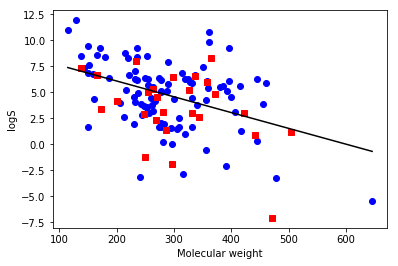

In [ ]:
#============================================================================
# BUILD SOME SAMPLE MODELS TO PREDICT SOLUBILITY
#    You will want to read this code and make sure you get it, as your task takes off from here
#============================================================================
#SIMPLE MODEL #1: Predict solubility based on molecular weight alone
#============================================================================


#Build a really really simple model -- predict solubility based on molecular weight

#To do this, start by obtaining molecular weights -- for both the knowns (training set) and unknowns (test set)
#Make a list of molecular weight for the knowns, convert to array
known_mw = [ compounds[mol]['mw'] for mol in knownnames ]
known_mw = np.array(known_mw)
#Make a list of molecular weights to predict (test set), convert to array
p_mw = [compounds[mol]['mw'] for mol in predictnames ]
p_mw = np.array(p_mw)

#Our model will have the form (using y for logS, the log of the solubility), y = m*(mw) + b, which we rewrite (to feed into numpy) as y = A * p where A is an array consisting of [ mw, 1] and p is [m, b].
A = np.vstack( [known_mw, np.ones( len(known_mw) )] ).T #Write the array -- first our x value, then a 1 for the constant term

#Solve for coefficients using least squares fit -- we just put the array A and the thing we want to fit (known_solubilities) into the least squares algorithm and get back the coefficients m and b
m, b = np.linalg.lstsq( A, known_solubilities)[0]
print("Fit coefficients: %.2f, %.2f" % (m, b))

#Compute the calculated y values, y = m*x + b, for the test set
fittedvals = m*known_mw + b

#Compute some statistics for our model -- Kendall tau, RMS error, correlation coefficient
ktau, pvalue = scipy.stats.kendalltau( known_solubilities, fittedvals)
rms = tools.rmserr( known_solubilities, fittedvals)
R2 = tools.correl( known_solubilities, fittedvals)**2
print("For initial (molecular weight) model training, Kendall tau is %.2f, RMS error is %.2f, and Rsquared is %.2f. Probability of getting this Kendall tau value when in fact there is no correlation (null hypothesis): %.2g" % (ktau, rms, R2, pvalue))

#Now test its predictive power by applying it to the test set
predictvals = m*p_mw + b
ktau, pvalue = scipy.stats.kendalltau( predict_solubilities, predictvals)
rms = tools.rmserr( predict_solubilities, predictvals)
R2 = tools.correl( predict_solubilities, predictvals)**2
halflog = tools.percent_within_half( predict_solubilities, predictvals ) #Figure out percentage within 0.5 log units
print("For initial (molecular weight) model test, Kendall tau is %.2f, RMS error is %.2f, and Rsquared is %.2f. Probability of getting this Kendall tau value when in fact there is no correlation (null hypothesis): %.2g. Percentage within 0.5 log units: %.2f" % (ktau, rms, R2, pvalue, halflog))

#Now, for fun, take all of the data (training and test set) and do a plot of the actual values versus molecular weight (for test and training set separately) and then an overlay of the predicted fit
plot( known_mw, known_solubilities, 'bo' ) #Plot knowns with blue circles
plot( p_mw, predict_solubilities, 'rs' ) #Plot test set with red squares

#Do a plot of the predicted fit
#First, figure out molecular weight range
minmw = min( known_mw.min(), p_mw.min() )
maxmw = max( known_mw.max(), p_mw.max() )
#Compute solubility estimates corresponding to the minimum and maximum
minsol = m*minmw+b
maxsol = m*maxmw+b
#Plot a line
plot( [ minmw, maxmw], [minsol, maxsol], 'k-' ) #Plot as a black line overlaid
xlabel('Molecular weight')
ylabel('logS')

# Show figure
show()

#Save figure
savefig('mw_model.pdf')
#Clear
figure()

## Build another simple model

In [ ]:
#============================================================================
#SIMPLE MODEL #2: Predict based on hydration free energy (ought to have something to do with solubility) plus molecular weight
#============================================================================


#Build another model -- this time using hydration free energy plus molecular weight (should do better on training set, not clear if it will on test set)
print("\nHydration plus mw model:")
known_hydr = [ compounds[mol]['hydration'] for mol in knownnames] #Build a list of hydration free energies for the knowns, with names listed in knownnames (that is, hydration free energies for the training set)
known_hydr = np.array(known_hydr) #Convert this to a numpy array
p_hydr = [ compounds[mol]['hydration'] for mol in predictnames] #Build list of hydration free energies for the test set
p_hydr = np.array(p_hydr) #Convert to numpy array

#Prep for least squares fit and perform it
A = np.vstack( [known_mw, known_hydr, np.ones(len(known_mw) ) ] ).T #Write array for fit -- see more detailed discussion above in the molecular weight section
#Solve for coefficients
m, n, b = np.linalg.lstsq( A, known_solubilities)[0]
print("Fit coefficients: %.2f (mw), %.2f (hyd), %.2f (constant)" % (m, n, b))
fittedvals = m*known_mw + n*known_hydr + b #Calculate the values we 'predict' based on our model for the training set

#Computed test set results too
predictvals = m*p_mw + n*p_hydr + b

#Do stats -- training set
#Compute kendall tau and pvalue
ktau, pvalue = scipy.stats.kendalltau( known_solubilities, fittedvals)
#RMS error
rms = tools.rmserr( known_solubilities, fittedvals)
#Correlation coefficient
R2 = tools.correl( known_solubilities, fittedvals)**2
halflog = tools.percent_within_half( predict_solubilities, predictvals ) #Figure out percentage within 0.5 log units
print("For mw+hydration model test, Kendall tau is %.2f, RMS error is %.2f, and Rsquared is %.2f. Probability of getting this Kendall tau value when in fact there is no correlation (null hypothesis): %.2g. Percentage within 0.5 log units: %.2f" % (ktau, rms, R2, pvalue, halflog))


Hydration plus mw model:
Fit coefficients: -0.02 (mw), -0.15 (hyd), 7.93 (constant)
For mw+hydration model test, Kendall tau is 0.37, RMS error is 2.61, and Rsquared is 0.34. Probability of getting this Kendall tau value when in fact there is no correlation (null hypothesis): 1.2e-07. Percentage within 0.5 log units: 15.38


# Do your assignment below

In [ ]:
#============================================================================
#ADD YOUR MODELS HERE, FOLLOWING THE PATTERNS OF THE TWO SIMPLE MODELS ABOVE
#============================================================================